# Stock Price Prediction using Recurrent Neural Networks (RNNs)

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas_datareader as web
import plotly.express as px
import math
plt.style.use('ggplot')

## Load Stock Data

In [2]:
# Loading S&P 500 stock data from July 24, 2015 to July 24, 2020
sp500 = web.DataReader('^GSPC', data_source = 'yahoo', start = '2015-07-24', end = '2020-07-24')
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-07-24,2106.010010,2077.090088,2102.239990,2079.649902,3870040000,2079.649902
2015-07-27,2078.189941,2063.520020,2078.189941,2067.639893,3836750000,2067.639893
2015-07-28,2095.600098,2069.090088,2070.750000,2093.250000,4117740000,2093.250000
2015-07-29,2110.600098,2094.080078,2094.699951,2108.570068,4038900000,2108.570068
2015-07-30,2110.479980,2094.969971,2106.780029,2108.629883,3579410000,2108.629883
...,...,...,...,...,...,...
2020-07-20,3258.610107,3215.159912,3224.290039,3251.840088,3971200000,3251.840088
2020-07-21,3277.290039,3247.770020,3268.520020,3257.300049,4547960000,3257.300049
2020-07-22,3279.320068,3253.100098,3254.860107,3276.020020,4255190000,3276.020020


## Visualize Stock Data

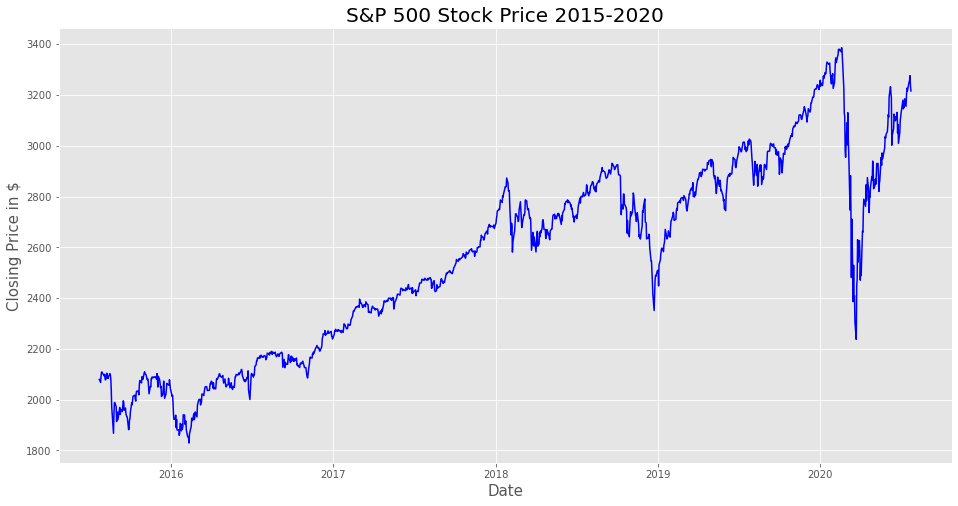

In [3]:
plt.figure(1, figsize = (16,8))
plt.plot(sp500['Close'], c = 'blue')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Closing Price in $', fontsize = 15)
plt.title('S&P 500 Stock Price 2015-2020', fontsize = 20)
plt.show()

## Preprocessing

In [4]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

### Convert Dataset into NumPy Array

In [5]:
# We are using the close price as our dataset
data = sp500['Close']
data = np.array(data).reshape(-1,1)

### Scale the Data

### Train - Test Split

In [6]:
# We are going to set the number of samples the train and test subsets will get
# We are going to do an 80-20 split of the data
num_train_samples = int(data.shape[0] * .8)
num_test_samples = data.shape[0] - num_train_samples

print('Train Samples: ', num_train_samples)
print('Test Samples: ', num_test_samples)

Train Samples:  1008
Test Samples:  252


In [7]:
# We will now make our train and test subsets
train_data = data[: num_train_samples]
test_data = data[num_train_samples : num_train_samples + num_test_samples]

# We have to convert both subsets to a numpy array to feed into the model
train_data = np.array(train_data).reshape(-1,1)
test_data = np.array(test_data).reshape(-1,1)

In [8]:
# The model is sensitive to scale so we are going to make the data from a range of [0,1]
# We will scale the train and test subsets individually to prevent data leakage
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.fit_transform(test_data)


In [9]:
# time_step is how many days we want to use to predict the time_step + 1 value
# We will makea function to make the features and targets in each subset
def make_inputs_targets(data, time_step):
    X = []
    y = []
    
    for i in range(data.shape[0] - time_step):
        X.append(data[i : time_step + i, 0])
        y.append(data[i + time_step, 0])
    
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = make_inputs_targets(train_data, time_step)
X_test, y_test = make_inputs_targets(test_data, time_step)

In [10]:
# Will output (samples, time_steps, features)
X_train.shape

(908, 100)

In [11]:
# LSTM input requires 3 dimensional size (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Simple RNN Model

In [12]:
# Our first model will be the Simple RNN model, and we will use this as a baseline
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.SimpleRNN(60, return_sequences = True, input_shape = (X_train.shape[1],1)))
model_rnn.add(tf.keras.layers.SimpleRNN(60, return_sequences = True))
model_rnn.add(tf.keras.layers.SimpleRNN(60))
model_rnn.add(tf.keras.layers.Dense(1))
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 100, 60)           3720      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100, 60)           7260      
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 60)                7260      
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 18,301
Trainable params: 18,301
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Here we will compile the model using a mean squared error loss function and an adam optimizer
model_rnn.compile(loss = 'mean_squared_error', optimizer = 'adam')

# We want to implement a measure that will prevent overfitting, so we will use an early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 3)

history_rnn = model_rnn.fit(X_train, y_train, 
          validation_data = (X_test, y_test), 
          epochs = 100, 
          callbacks = [early_stopping],
          batch_size = 25, 
          verbose = 2)

Epoch 1/100
37/37 - 2s - loss: 0.0255 - val_loss: 0.0091
Epoch 2/100
37/37 - 2s - loss: 0.0010 - val_loss: 0.0072
Epoch 3/100
37/37 - 2s - loss: 7.5717e-04 - val_loss: 0.0070
Epoch 4/100
37/37 - 2s - loss: 6.3417e-04 - val_loss: 0.0063
Epoch 5/100
37/37 - 2s - loss: 6.2959e-04 - val_loss: 0.0060
Epoch 6/100
37/37 - 2s - loss: 6.5229e-04 - val_loss: 0.0060
Epoch 7/100
37/37 - 2s - loss: 8.3244e-04 - val_loss: 0.0054
Epoch 8/100
37/37 - 2s - loss: 5.8038e-04 - val_loss: 0.0054
Epoch 9/100
37/37 - 2s - loss: 5.8050e-04 - val_loss: 0.0055
Epoch 10/100
37/37 - 2s - loss: 7.9832e-04 - val_loss: 0.0049
Epoch 11/100
37/37 - 2s - loss: 5.5640e-04 - val_loss: 0.0048
Epoch 12/100
37/37 - 2s - loss: 5.8913e-04 - val_loss: 0.0048
Epoch 13/100
37/37 - 2s - loss: 5.9870e-04 - val_loss: 0.0045
Epoch 14/100
37/37 - 2s - loss: 5.9597e-04 - val_loss: 0.0049
Epoch 15/100
37/37 - 2s - loss: 0.0011 - val_loss: 0.0048
Epoch 16/100
37/37 - 2s - loss: 7.1578e-04 - val_loss: 0.0048


## Visualize Simple RNN Model Performance

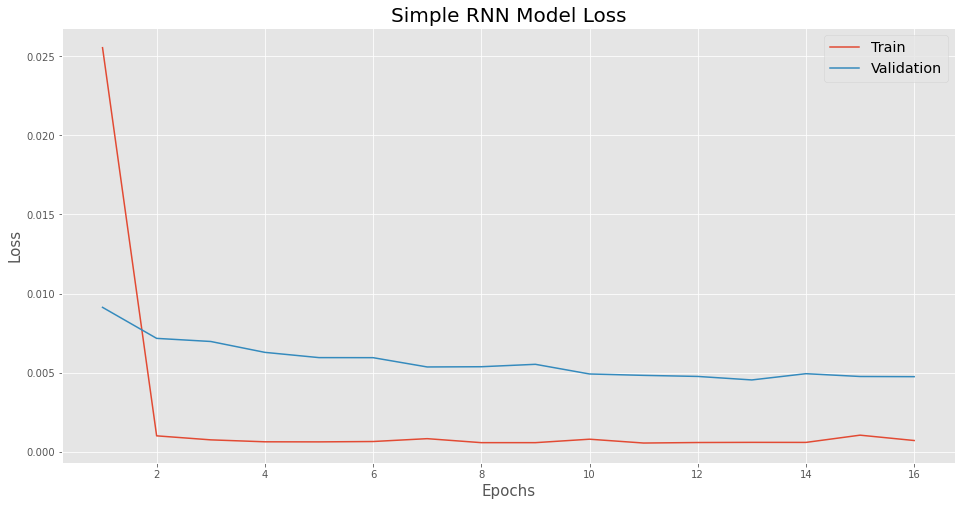

In [14]:
# To visualize how the model performed over each epoch, we will plot the train and validation loss on a graph
loss = history_rnn.history['loss']
val_loss = history_rnn.history['val_loss']
epochs_range = range(1, len(history_rnn.epoch) + 1)

plt.figure(1, figsize = (16,8))
plt.plot(epochs_range, loss, label='Train')
plt.plot(epochs_range, val_loss, label='Validation')
plt.legend(loc="best", fontsize = 'x-large')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.title('Simple RNN Model Loss', fontsize = 20)

plt.show()

## Get Simple RNN Model Predictions

In [15]:
# We will get the predictions of the model on the train and validation subsets
y_train_pred_rnn = model_rnn.predict(X_train)
y_test_pred_rnn = model_rnn.predict(X_test)

In [16]:
# The predictions are scaled but we want to see the actual price predictions so we have to use .inverse_transform()
y_train_reg = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_reg = scaler.inverse_transform(y_test.reshape(-1,1))

y_train_pred_rnn = scaler.inverse_transform(y_train_pred_rnn)
y_test_pred_rnn = scaler.inverse_transform(y_test_pred_rnn)

In [17]:
# Let's see how the model performed by calculating root mean squared error
print('ROOT MEAN SQUARED ERROR OF TRAIN AND TEST SUBSETS')
print('')
print('Train: ', math.sqrt(mean_squared_error(y_train_reg, y_train_pred_rnn)))
print('Test: ', math.sqrt(mean_squared_error(y_test_reg, y_test_pred_rnn)))

ROOT MEAN SQUARED ERROR OF TRAIN AND TEST SUBSETS

Train:  32.788202309151416
Test:  79.1748831309624


## Visualize Simple RNN Predictions

In [18]:
# We have to graph the predictions in comparision with the original closing price
# the predictions are in a numpy array, so to make things easier we will turn them into a dataframe
train_pred_rnn = pd.DataFrame(y_train_pred_rnn, columns = ['y_train_pred_rnn'])
test_pred_rnn = pd.DataFrame(y_test_pred_rnn, columns = ['y_test_pred_rnn'])

# We are going to modify the indices of each dataframe, because we have to make the predictions line up with the graph

# We are shifting the indicies of train_pred by time_step because we used the first time_step days to predict the time_step+1th day 
train_pred_rnn.index = train_pred_rnn.index + time_step

test_pred_rnn.index = test_pred_rnn.index + train_pred_rnn.shape[0] + time_step*2

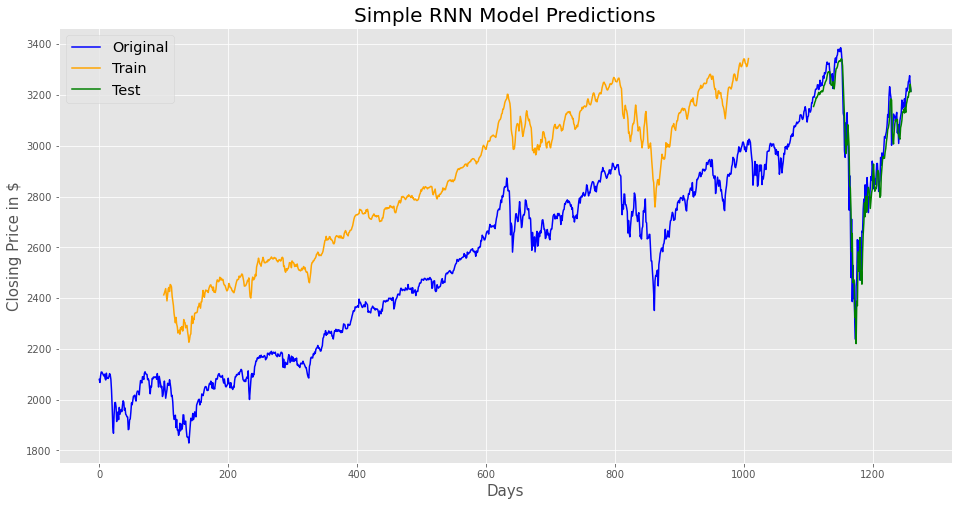

In [19]:
plt.figure(1, figsize = (16,8))
plt.plot(sp500['Close'].reset_index(drop = True), c = 'blue')
plt.plot(train_pred_rnn, c = 'orange')
plt.plot(test_pred_rnn, c = 'green')
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Closing Price in $', fontsize = 15)
plt.title('Simple RNN Model Predictions', fontsize = 20)
plt.legend(['Original', 'Train', 'Test'], fontsize = 'x-large')
plt.show()

## LSTM Model

In [20]:
# Our next model, we will use an LSTM network
# We should get slightly better predictions than last time
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_lstm.add(tf.keras.layers.LSTM(60, return_sequences = True))
model_lstm.add(tf.keras.layers.LSTM(60))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 60)           14880     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 60)           29040     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 73,021
Trainable params: 73,021
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.compile(loss = 'mean_squared_error', optimizer = 'adam')

history_lstm = model_lstm.fit(X_train, y_train, 
          validation_data = (X_test, y_test), 
          epochs = 100, 
          callbacks = [early_stopping],
          batch_size = 25, 
          verbose = 2)

Epoch 1/100
37/37 - 4s - loss: 0.0376 - val_loss: 0.0300
Epoch 2/100
37/37 - 3s - loss: 0.0026 - val_loss: 0.0312
Epoch 3/100
37/37 - 3s - loss: 0.0022 - val_loss: 0.0300
Epoch 4/100
37/37 - 3s - loss: 0.0021 - val_loss: 0.0278
Epoch 5/100
37/37 - 3s - loss: 0.0023 - val_loss: 0.0260
Epoch 6/100
37/37 - 3s - loss: 0.0019 - val_loss: 0.0249
Epoch 7/100
37/37 - 3s - loss: 0.0019 - val_loss: 0.0223
Epoch 8/100
37/37 - 3s - loss: 0.0019 - val_loss: 0.0219
Epoch 9/100
37/37 - 3s - loss: 0.0019 - val_loss: 0.0215
Epoch 10/100
37/37 - 3s - loss: 0.0017 - val_loss: 0.0181
Epoch 11/100
37/37 - 3s - loss: 0.0018 - val_loss: 0.0169
Epoch 12/100
37/37 - 3s - loss: 0.0021 - val_loss: 0.0167
Epoch 13/100
37/37 - 3s - loss: 0.0014 - val_loss: 0.0159
Epoch 14/100
37/37 - 3s - loss: 0.0017 - val_loss: 0.0141
Epoch 15/100
37/37 - 3s - loss: 0.0013 - val_loss: 0.0128
Epoch 16/100
37/37 - 3s - loss: 0.0013 - val_loss: 0.0120
Epoch 17/100
37/37 - 3s - loss: 0.0012 - val_loss: 0.0120
Epoch 18/100
37/37 - 3s

## Visualize LSTM Model Performance

In [ ]:
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
epochs_range = range(1, len(history_lstm.epoch) + 1)

plt.figure(1, figsize = (16,8))
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Loss')

plt.show()

## Get LSTM Model Predictions

In [ ]:
y_train_pred_lstm = model_lstm.predict(X_train)
y_test_pred_lstm = model_lstm.predict(X_test)

In [ ]:
y_train_pred_lstm = scaler.inverse_transform(y_train_pred_lstm)
y_test_pred_lstm = scaler.inverse_transform(y_test_pred_lstm)

## Visualize  LSTM Predictions

In [ ]:
train_pred_lstm = pd.DataFrame(y_train_pred_lstm, columns = ['y_train_pred_lstm'])
test_pred_lstm = pd.DataFrame(y_test_pred_lstm, columns = ['y_test_pred_lstm'])

train_pred_lstm.index = train_pred_lstm.index + time_step

test_pred_lstm.index = test_pred_lstm.index + train_pred_lstm.shape[0] + time_step*2

In [ ]:
plt.figure(1, figsize = (16,8))
plt.plot(sp500['Close'].reset_index(drop = True), c = 'blue')
plt.plot(train_pred_lstm, c = 'orange')
plt.plot(test_pred_lstm, c = 'green')
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Closing Price in $', fontsize = 15)
plt.title('LSTM Model Predictions', fontsize = 20)
plt.legend(['Original', 'Train', 'Test'], fontsize = 'x-large')
plt.show()

## GRU Model

In [ ]:
# Our last model will be a GRU model
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model_gru.add(tf.keras.layers.GRU(60, return_sequences = True))
model_gru.add(tf.keras.layers.GRU(60))
model_gru.add(tf.keras.layers.Dense(1))
model_gru.summary()

In [ ]:
model_gru.compile(loss = 'mean_squared_error', optimizer = 'adam')

history_gru = model_gru.fit(X_train, y_train, 
          validation_data = (X_test, y_test), 
          epochs = 100, 
          callbacks = [early_stopping],
          batch_size = 25, 
          verbose = 2)

In [ ]:
# plot model performance
loss = history_gru.history['loss']
val_loss = history_gru.history['val_loss']
epochs_range = range(1, len(history_gru.epoch) + 1)

plt.figure(1, figsize = (16,8))
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GRU Model Loss')

plt.show()

In [ ]:
y_train_pred_gru = model_gru.predict(X_train)
y_test_pred_gru = model_gru.predict(X_test)

In [ ]:
# Unscale the predictions, so we can see the actual price prediction
y_train_pred_gru = scaler.inverse_transform(y_train_pred_gru)
y_test_pred_gru = scaler.inverse_transform(y_test_pred_gru)

In [ ]:
train_pred_gru = pd.DataFrame(y_train_pred_gru, columns = ['y_train_pred_gru'])
test_pred_gru = pd.DataFrame(y_test_pred_gru, columns = ['y_test_pred_gru'])

train_pred_gru.index = train_pred_gru.index + time_step

test_pred_gru.index = test_pred_gru.index + train_pred_lstm.shape[0] + time_step*2

In [ ]:
plt.figure(1, figsize = (16,8))
plt.plot(sp500['Close'].reset_index(drop = True), c = 'blue')
plt.plot(train_pred_gru, c = 'orange')
plt.plot(test_pred_gru, c = 'green')
plt.xlabel('Days', fontsize = 15)
plt.ylabel('Closing Price in $', fontsize = 15)
plt.title('LSTM Model Predictions', fontsize = 20)
plt.legend(['Original', 'Train', 'Test'], fontsize = 'x-large')
plt.show()

## Compare the RMSE

In [ ]:
# We will calculate the root mean squared error of each of the model predictions to see how accurate the model really was
print('SIMPLE RNN')
print('')
print('Train: ', round(math.sqrt(mean_squared_error(y_train_reg, y_train_pred_rnn)), 3))
print('Test:  ', round(math.sqrt(mean_squared_error(y_test_reg, y_test_pred_rnn)), 3))
print('')
print('LSTM')
print('')
print('Train: ', round(math.sqrt(mean_squared_error(y_train_reg, y_train_pred_lstm)), 3))
print('Test:  ', round(math.sqrt(mean_squared_error(y_test_reg, y_test_pred_lstm)), 3))
print('')
print('GRU')
print('')
print('Train: ', round(math.sqrt(mean_squared_error(y_train_reg, y_train_pred_gru)), 3))
print('Test:  ', round(math.sqrt(mean_squared_error(y_test_reg, y_test_pred_gru)), 3))

The GRU model had the best accuracy as it had the lowest RMSE of the three models tested.